In [61]:
import pathlib

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
df = pd.read_csv("../data/main.csv")

In [96]:
min_max_scaler = preprocessing.MinMaxScaler()

df["H*theta_r_r"] = df["H"] * df["theta_r"] * df["r"]
df["H*theta_r"] = df["H"] * df["theta_r"]

input_columns = ["r", "theta_r", "H", "F", "gamma", "alpha", "beta", "H*theta_r_r", "H*theta_r"]

np_scaled = min_max_scaler.fit_transform(df[input_columns])
df_normalized = pd.DataFrame(np_scaled, columns=input_columns)
df = pd.merge(df_normalized, df.drop(input_columns, axis=1),  left_index=True, right_index=True)

In [97]:
df.head()

,r,theta_r,H,F,gamma,alpha,beta,H*theta_r_r,H*theta_r,indiscriminate_stable,selective_stable,mixed_stable,indiscriminate_evol_stable,selective_evol_stable,mixed_evol_stable
0,0.200000,0.000000,1.000000,0.800000,0.000000,0.200000,0.800000,0.000000,0.000000,True,False,NaN,False,False,False
1,0.166667,0.333333,0.333333,0.166667,0.166667,0.500000,0.166667,0.018519,0.111111,True,False,NaN,False,False,False
2,0.750000,0.250000,0.750000,0.000000,1.000000,0.000000,0.500000,0.140625,0.187500,True,False,NaN,False,False,False
3,0.166667,0.166667,0.500000,0.500000,0.500000,0.333333,0.000000,0.013889,0.083333,True,False,NaN,False,False,False
4,0.000000,1.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,0.000000,True,True,0.0,False,False,False


In [98]:
df.describe()

,r,theta_r,H,F,gamma,alpha,beta,H*theta_r_r,H*theta_r,mixed_stable
count,136485.000000,136485.000000,136485.000000,136485.000000,136485.000000,136485.000000,136485.000000,136485.000000,136485.000000,4.128500e+04
mean,0.259949,0.435652,0.502937,0.496980,0.499314,0.499809,0.499933,0.059318,0.214892,1.537671e-14
std,0.251661,0.335146,0.346155,0.347973,0.348370,0.348531,0.348555,0.120329,0.253774,1.665362e-13
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.200000,0.250000,0.200000,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000e+00
50%,0.200000,0.400000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,0.125000,0.000000e+00
75%,0.500000,0.750000,0.800000,0.800000,0.800000,0.800000,0.800000,0.064000,0.375000,0.000000e+00
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.818989e-12


The above is a large data set of parameters and findings about the stability. The following are inputs:

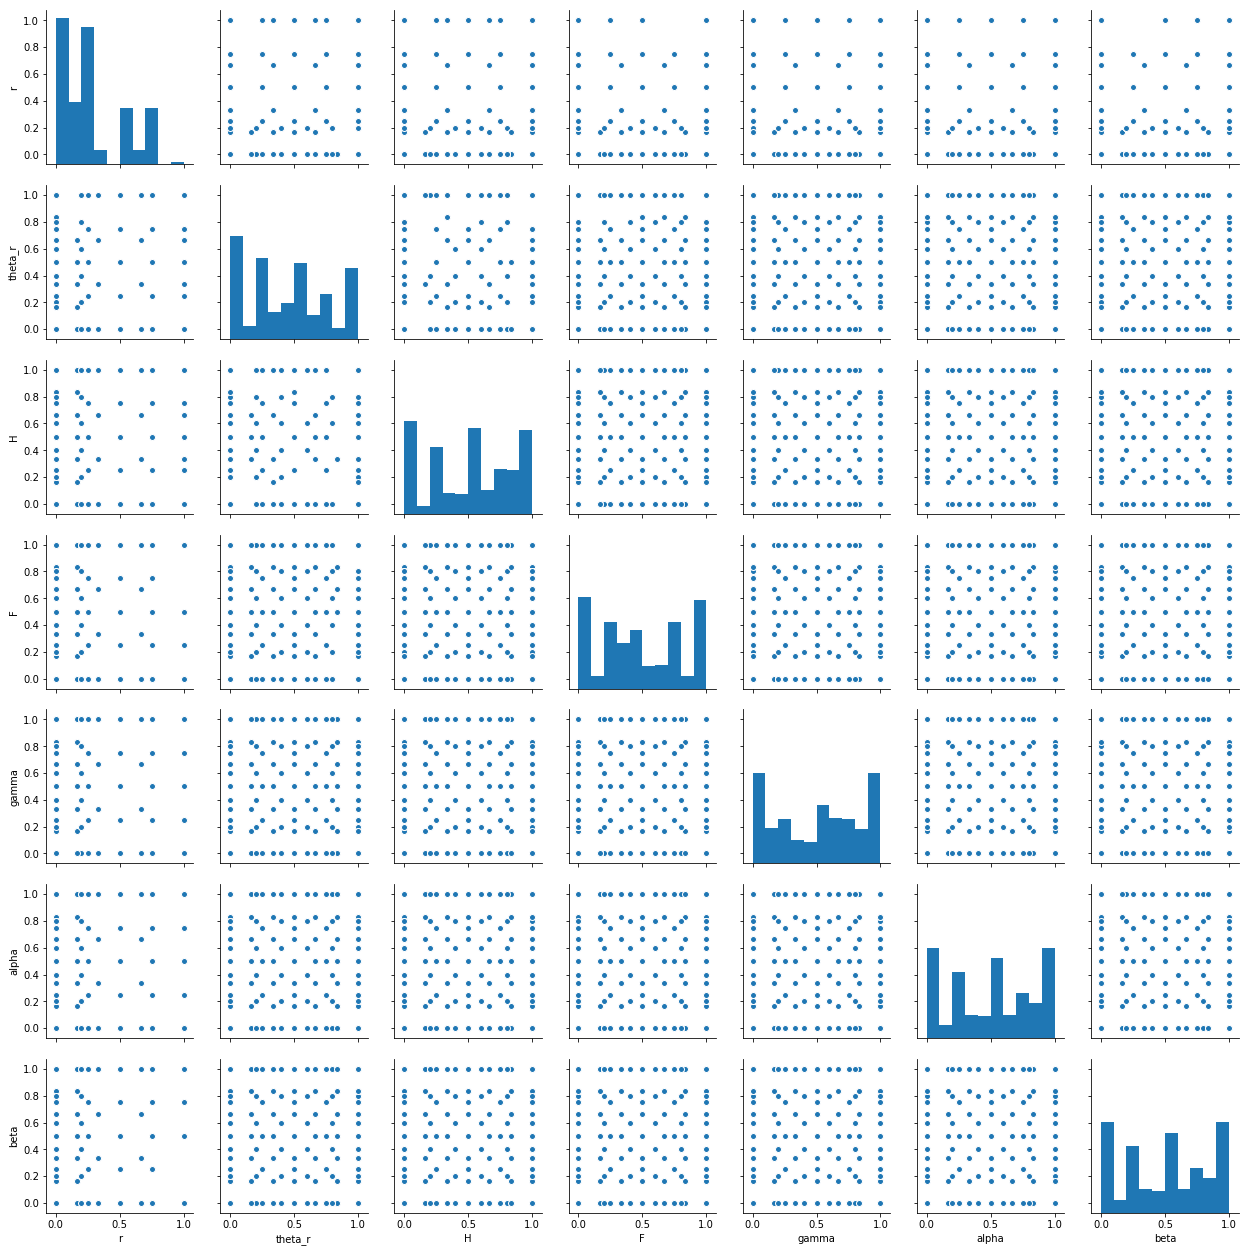

In [99]:
X = df[['r', 'theta_r', 'H', 'F', 'gamma', 'alpha', 'beta']]
sns.pairplot(X);

None of our data exhibits a mixed strategy equilibria (I have reasons to believe we have not checked this correctly though).

In [100]:
df[(df["mixed_stable"].isnull() > 0) & (df["mixed_stable"].isnull() < 1)]

,r,theta_r,H,F,gamma,alpha,beta,H*theta_r_r,H*theta_r,indiscriminate_stable,selective_stable,mixed_stable,indiscriminate_evol_stable,selective_evol_stable,mixed_evol_stable


## Indiscriminate poachers

Indiscriminate is always stable in our data (could just be because the parameters have not had time explore the full space).

In [101]:
sum(df["indiscriminate_stable"] == True) / df["indiscriminate_stable"].count()

0.99609480895336489

It is however: never evolutionary stable.

In [102]:
sum(df["indiscriminate_evol_stable"] == True) / df["indiscriminate_stable"].count()

0.0

## Selective poachers

We confirm that selective is however not always stable:

In [103]:
sum(df["selective_stable"] == True) / df["selective_stable"].count()

0.29993039528153276

Never evolutionary stable.

In [104]:
sum(df["selective_evol_stable"] == True) / df["selective_stable"].count()

0.0

TODO: Confirm the equations for testing Selective and Indiscriminate stability.

### Feature importance for selective stability

Let us now apply some basic machine learning to gain information from the multidimensional landscape we have built with our model.

In [110]:
X = df[input_columns]
Y = df["selective_stable"]

In [111]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [112]:
test = SelectKBest(score_func=chi2, k="all")
fit = test.fit(X, Y)

In [113]:
X.columns

Index(['r', 'theta_r', 'H', 'F', 'gamma', 'alpha', 'beta', 'H*theta_r_r',
       'H*theta_r'],
      dtype='object')

In [114]:
pd.DataFrame(list(zip(X.columns, fit.scores_)))

,0,1
0,r,15200.303532
1,theta_r,444.965335
2,H,68.971671
3,F,1.836868
4,gamma,0.326526
5,alpha,0.001867
6,beta,0.000006
7,H*theta_r_r,3468.573293
8,H*theta_r,149.503230


We see that the biggest predictor as to whether or not activing selective is stable is $H$: constant associated with the value of the full horn. Let us use recursive feature selection to identify/remove components that might have an effect based on cross correlations:

What if we were to selection

In [116]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# feature extraction
model = LogisticRegression()

supports = []
for number_of_variables in range(1, len(input_columns)):
    rfe = RFE(model, number_of_variables)
    fit = rfe.fit(X, Y)
    supports.append(fit.support_)
pd.DataFrame(list(zip(X.columns, *supports)))

,0,1,2,3,4,5,6,7,8
0,r,True,True,True,True,True,True,True,True
1,theta_r,False,False,True,True,True,True,True,True
2,H,False,False,False,False,True,True,True,True
3,F,False,False,False,False,False,True,True,True
4,gamma,False,False,False,False,False,False,False,False
5,alpha,False,False,False,False,False,False,False,True
6,beta,False,False,False,False,False,False,True,True
7,H*theta_r_r,False,True,True,True,True,True,True,True
8,H*theta_r,False,False,False,True,True,True,True,True


We see that the single most important feature is $r$.

- The top two important features: $r$ and $\theta_r$
- The top three: $r$, $\theta_r$ and $\gamma$

$H$ is in fact not selected until all features are selected. This indicates that it probably cross correlates. (I think)

Let us take a look at Principal component analysis to essentially "redimension" our model:

In [118]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
fit = pca.fit(X)
# summarize components
print("Explained Variance: {}".format(fit.explained_variance_ratio_))
pd.DataFrame(list(zip(X.columns, *fit.components_)))

Explained Variance: [ 0.2014697   0.14145195  0.14131973  0.14127461]


,0,1,2,3,4
0,r,0.078846,0.018047,0.005344,0.010573
1,theta_r,0.540952,0.284776,0.071264,0.155908
2,H,0.572557,-0.303754,-0.078587,-0.169002
3,F,-0.034581,-0.481376,-0.128448,-0.282017
4,gamma,0.008526,-0.687705,0.067120,-0.118476
5,alpha,0.000560,0.305452,-0.617298,-0.684430
6,beta,-0.000264,-0.167892,-0.765932,0.620460
7,H*theta_r_r,0.188342,0.006946,0.001445,0.003396
8,H*theta_r,0.580165,0.010578,0.001519,0.004750


The first compoonent is almost entirely made up of $H$ and explains 99%. I don't think this helps much or how it corresponds to the rest...

In [119]:
from sklearn.ensemble import ExtraTreesClassifier

# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
pd.DataFrame(list(zip(X.columns, model.feature_importances_)))

,0,1
0,r,0.862893
1,theta_r,0.017053
2,H,0.002588
3,F,0.000784
4,gamma,0.000390
5,alpha,0.000093
6,beta,0.000208
7,H*theta_r_r,0.105618
8,H*theta_r,0.010374


The main thing that keep seeming to come back as is the importance of $r$.


Let us fit a model to our data and take a look. First let us just fit a model when using $r$ as the predictor:

In [120]:
model = linear_model.LogisticRegression()
model.fit(X[["r"]], Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [121]:
rs = np.linspace(0, 1, 1000)
probabilities = [model.predict_proba([[r]]) for r in rs]

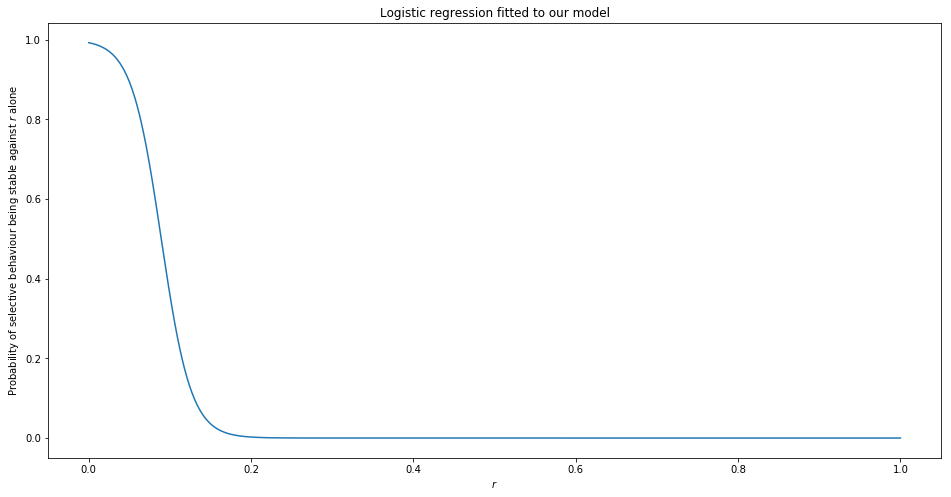

In [122]:
plt.rcParams['figure.figsize'] = 16, 8

plt.plot(rs, [prediction[0][list(model.classes_).index(True)] for prediction in probabilities])
plt.xlabel("$r$")
plt.ylabel("Probability of selective behaviour being stable against $r$ alone")
plt.title("Logistic regression fitted to our model");

Let us take a look at $H$:

In [132]:
model = linear_model.LogisticRegression()
model.fit(X[["H"]], Y)
Hs = np.linspace(0, 1000, 5000)
probabilities = [model.predict_proba([[H]]) for H in Hs]

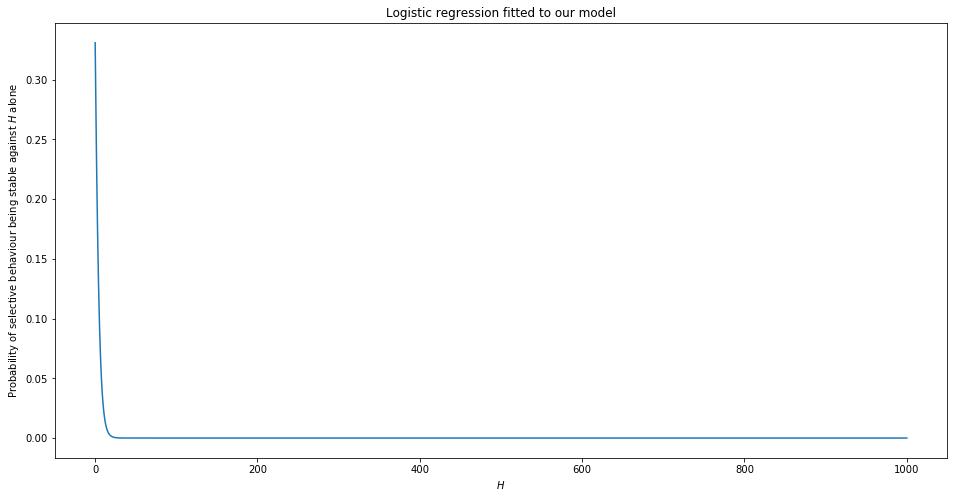

In [133]:
plt.plot(Hs, [prediction[0][list(model.classes_).index(True)] for prediction in probabilities])
plt.xlabel("$H$")
plt.ylabel("Probability of selective behaviour being stable against $H$ alone")
plt.title("Logistic regression fitted to our model");

Let us take a look at the effect of both $H$ and $r$

In [134]:
model = linear_model.LogisticRegression()
model.fit(X[["r", "H"]], Y)
rs = np.linspace(0, 1, 100)
Hs = np.linspace(0, 1000, 100)
probabilities = np.array([[model.predict_proba([[r, H]])[0][list(model.classes_).index(True)] for r in rs] for H in Hs])

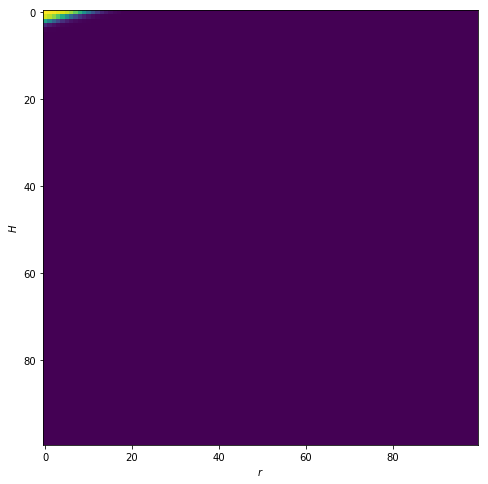

In [135]:
plt.imshow(probabilities)
plt.xlabel("$r$")
plt.ylabel("$H$");

We see that $r$ is the only thing affecting our logistic regression model.

Let us now consider all of the input features.

In [136]:
model = linear_model.LogisticRegression()
model.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

A number of scenarios in which we will see the effect of $r$


In [137]:
        #  theta_r,  H,  F,, gamma, alpha, beta
    # TODO Need to reverse what the sklearn preprocessor is doing. (
    # To do so need to know what Max, Min was in original df)
scenarios = [[0.2, 100, 10, .25, .25, .25],
             [0.5, 100, 10, .25, .25, .25],
             [0.8, 100, 10, .25, .25, .25],
             [0.2, 200, 500, .25, .25, .25],
             [0.2, 300, 700, .25, .25, .25],
             [0.8, 400, 10000, .25, .25, .25]]
probabilities = [model.predict_proba([[r] + scenario for scenario in scenarios]) for r in rs]


ValueError: X has 7 features per sample; expecting 9

In [129]:
plt.rcParams['figure.figsize'] = 16, 8
for i, scenario in enumerate(scenarios):
    plt.plot(rs, [prediction[i][list(model.classes_).index(True)] for prediction in probabilities],
             label="$\\theta_r={},  H={},  F={}, \gamma={}, \alpha={}, \beta={}$".format(*scenario))
plt.legend()
plt.xlabel("$r$")
plt.ylabel("Probability of selective behaviour being stable")
plt.title("Logistic regression fitted to our model");

IndexError: invalid index to scalar variable.

Let us try a different predictive classifier, a decision tree:

In [34]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

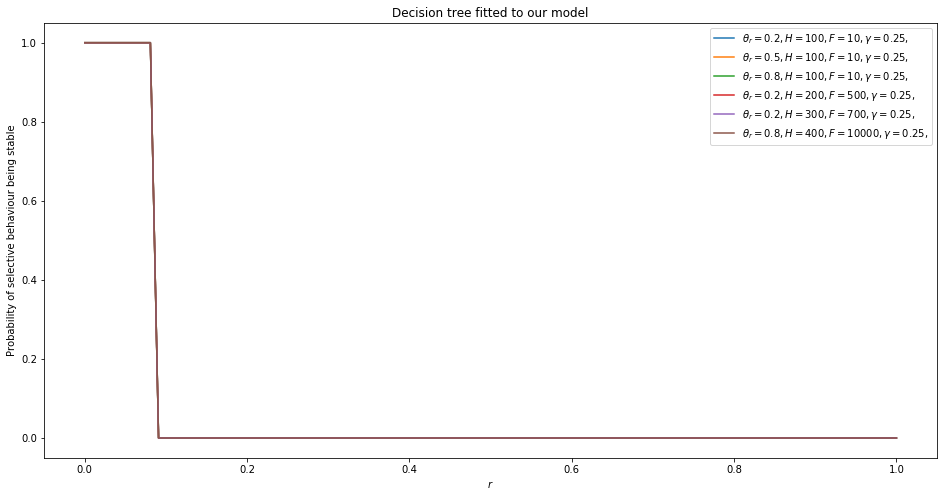

In [35]:
probabilities = [model.predict_proba([[r] + scenario for scenario in scenarios]) for r in rs]
plt.rcParams['figure.figsize'] = 16, 8
for i, scenario in enumerate(scenarios):
    plt.plot(rs, [prediction[i][list(model.classes_).index(True)] for prediction in probabilities],
             label="$\\theta_r={},  H={},  F={}, \gamma={}, \alpha={}, \beta={}$".format(*scenario))
plt.legend()
plt.xlabel("$r$")
plt.ylabel("Probability of selective behaviour being stable")
plt.title("Decision tree fitted to our model");

Random tree:

In [36]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

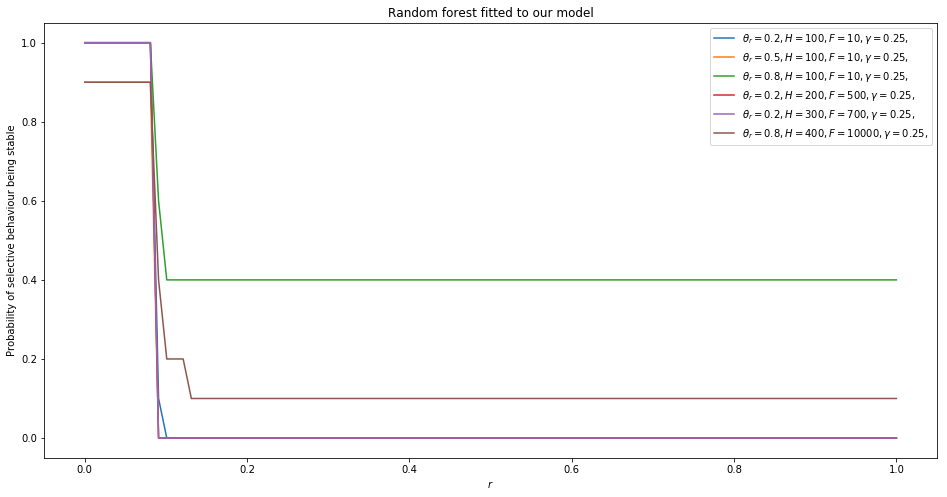

In [37]:
probabilities = [model.predict_proba([[r] + scenario for scenario in scenarios]) for r in rs]
plt.rcParams['figure.figsize'] = 16, 8
for i, scenario in enumerate(scenarios):
    plt.plot(rs, [prediction[i][list(model.classes_).index(True)] for prediction in probabilities],
             label="$\\theta_r={},  H={},  F={}, \gamma={}, \alpha={}, \beta={}$".format(*scenario))
plt.legend()
plt.xlabel("$r$")
plt.ylabel("Probability of selective behaviour being stable")
plt.title("Random forest fitted to our model");

## Summary

- $r$ is the only thing that (really) affects the probability of stability.
- $r\approx .1$ seems to be a cutoff point at which we will no longer have a stable situation.
- Sadly around $r\approx .1$ we will not have a large number of rhinos saved.

To do:

- Tidy the data and perhaps remove nonsense parameters? (If there are any, discuss with Tamsin).
- Rerun with normalised parameters and with extra transformed variables: $H\theta_r r$ and $H\theta_r$ ...
- Rerun the sweep looking at evolutionary stability